<a href="https://colab.research.google.com/github/shizoda/education/blob/main/machine_learning/basics/neural.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 機械学習体験プログラム

機械学習の主要な要素を体験しながら、ニューラルネットワークの仕組みや使い方を理解しましょう。

<a title="Dake, Mysid, CC BY 1.0 &lt;https://creativecommons.org/licenses/by/1.0&gt;, via Wikimedia Commons" href="https://commons.wikimedia.org/wiki/File:Neural_network.svg"><img width="512" alt="Neural network" src="https://upload.wikimedia.org/wikipedia/commons/thumb/3/3d/Neural_network.svg/512px-Neural_network.svg.png?20210102213114"></a>

## 必要なライブラリ

以下のライブラリをインポートします：
- `numpy`: 数値計算を効率的に行うためのライブラリ
- `scikit-learn`: 機械学習のためのライブラリ。分類、回帰、クラスタリングなど様々な機械学習アルゴリズムを提供します。
- `matplotlib`: データの可視化のためのライブラリ。グラフや図を簡単に描画できます。
- `pandas`: データ操作と分析のためのライブラリ。

In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris, load_wine, load_breast_cancer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, log_loss
from sklearn.utils import shuffle
import seaborn as sns
from tqdm import tqdm
random_state = 42  # 乱数のシード

## データセットの選択

いくつかの有名なデータセットから選択できます。各データセットの概要は以下の通りです：

| データセット名 | 目的 | 特徴量数 | 各特徴量 |
| --- | --- | --- | --- |
| Iris | 3種類のアヤメの品種を分類 | 4 | ガクの長さ・幅、花弁の長さ・幅 |
| Wine | 3種類のワインのタイプを分類 | 13 | アルコール度数、マグネシウム含有量など |
| Breast Cancer | 良性・悪性の腫瘍を分類 | 30 | 半径、テクスチャ、周囲長、面積など |
以下のコードを実行して、使用するデータセットを選択します。

In [2]:
print("データセットを選択してください：")
print("1: Iris")
print("2: Wine")
print("3: Breast Cancer")

dataset_number_str = input("番号を入力してください: ")

# 全角数字を半角に変換
dataset_number_str = dataset_number_str.translate(str.maketrans('１２３', '123'))

try:
    dataset_number = int(dataset_number_str)
except ValueError:
    dataset_number = None

from sklearn.datasets import load_iris, load_wine, load_breast_cancer
import pandas as pd
from sklearn.utils import shuffle
import sys
from IPython.display import display

# データセットをロードする関数
def load_dataset(dataset_number):
    if dataset_number == 1:
        dataset = load_iris()
        dataset_name = "Iris"
        feature_names = ["ガクの長さ", "ガクの幅", "花弁の長さ", "花弁の幅"]
        target_names = dataset.target_names
    elif dataset_number == 2:
        dataset = load_wine()
        dataset_name = "Wine"
        feature_names = dataset.feature_names
        target_names = dataset.target_names
    elif dataset_number == 3:
        dataset = load_breast_cancer()
        dataset_name = "Breast Cancer"
        feature_names = dataset.feature_names
        target_names = dataset.target_names
    else:
        print("誤った番号です")
        return None, None, None, None, None, None

    X = dataset.data
    y = dataset.target
    return dataset.data, dataset.target, pd.DataFrame(X, columns=feature_names), pd.Series(y, name="CLASS"), dataset_name, target_names, feature_names

# データセットのロード
X, y, feature_df, y_df, dataset_name, target_names, feature_names = load_dataset(dataset_number)

if X is not None:
    # クラス名を追加
    y_class_names = y_df.map(lambda x: target_names[x]).rename("CLASS_NAME")

    # 特徴量とクラス、クラス名を結合したDataFrameを作成
    df_combined = pd.concat([y_df, y_class_names, feature_df], axis=1)

    # データをシャッフル
    df_shuffled = shuffle(df_combined, random_state=42).reset_index(drop=True)

    # 表示
    display(df_shuffled.head())

データセットを選択してください：
1: Iris
2: Wine
3: Breast Cancer
番号を入力してください: 1


,CLASS,CLASS_NAME,ガクの長さ,ガクの幅,花弁の長さ,花弁の幅
0,1,versicolor,6.1,2.8,4.7,1.2
1,0,setosa,5.7,3.8,1.7,0.3
2,2,virginica,7.7,2.6,6.9,2.3
3,1,versicolor,6.0,2.9,4.5,1.5
4,1,versicolor,6.8,2.8,4.8,1.4


#### **課題 1**
- ひとつのサンプル（花，ワイン，患者）は行ですか，列ですか？
- この表では，各サンプルの
 - クラスはどこですか？
 - １つのサンプルごとに何次元の特徴量がありますか？
- ここからの機械学習モデルでは，＿＿＿＿＿＿＿ をもとに，そのデータの＿＿＿＿＿＿＿を推定します．


## データの準備と可視化

### データの構造を理解するための可視化

機械学習の第一歩として、データを理解することが重要です。まず、データセットの特徴量のうち2つを選んで散布図を描き、データの分布とクラスごとの関係を視覚化します。


<ipython-input-3-3899c7b1fdea>:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  return plt.cm.get_cmap('tab10', n_colors)


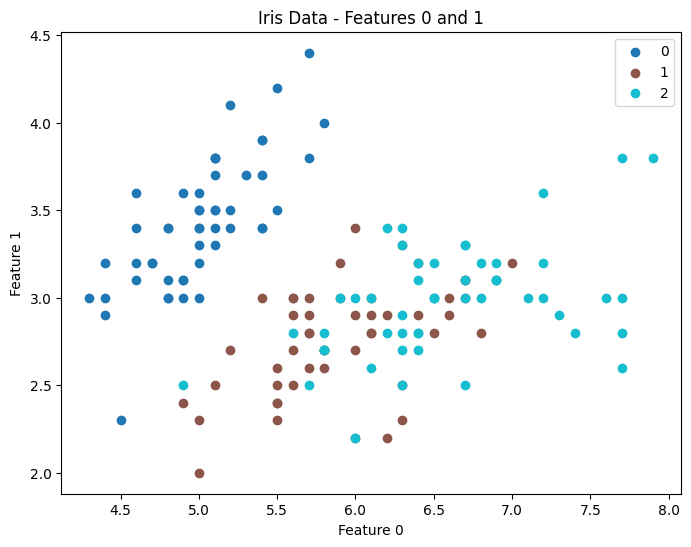

In [3]:
# 任意のクラス数に対応するカラーパレットを生成する関数
def generate_color_palette(n_colors):
    return plt.cm.get_cmap('tab10', n_colors)

# 特徴量のうち、2つを選んで散布図を描く関数
def plot_2d_projection(X, y, feature_indices, title=""):
    plt.figure(figsize=(8, 6))
    palette = generate_color_palette(len(np.unique(y)))
    for target in np.unique(y):
        subset = X[y == target]
        plt.scatter(subset[:, feature_indices[0]], subset[:, feature_indices[1]], label=target, color=palette(target))
    plt.xlabel(f"Feature {feature_indices[0]}")
    plt.ylabel(f"Feature {feature_indices[1]}")
    plt.title(title)
    plt.legend()
    plt.show()

# 特徴量の組み合わせを選んでプロット
plot_2d_projection(X.values if dataset_name == "Titanic" else X, y, feature_indices=[0, 1], title=f"{dataset_name} Data - Features 0 and 1")



### データの分割

データセット全体を1つの塊として使用するのではなく、以下の3つの部分に分割します：

1. **教師データ (training data)**:
   モデルの学習に使用します。このデータを使用して、モデルは特徴量と目標変数（ラベル）の関係を学びます。

2. **検証データ (validation data)**:
   モデルの性能を評価し、ハイパーパラメータの調整に使用します。教師データに含まれないデータを使うことで、モデルの汎化性能を確認します。

3. **テストデータ (test data)**:
   最終的なモデルの性能を評価するために使用します。このデータも教師データには含まれていません。テストデータの性能が高ければ、モデルは未知のデータに対しても良好に動作することが期待されます。


In [4]:
# One-hotエンコーディング
encoder = OneHotEncoder()
y_onehot = encoder.fit_transform(y.reshape(-1, 1)).toarray()

# データを分割 (70% training, 15% validation, 15% test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y_onehot, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# 分割結果の確認

# DataFrameの作成
def create_df(X, y, feature_names, target_names):
    y_classes = [target_names[i] for i in y.argmax(axis=1)]
    y_class_series = pd.Series(y_classes, name="CLASS_NAME")
    return pd.concat([pd.DataFrame(X, columns=feature_names), y_class_series], axis=1)

df_train = create_df(X_train, y_train, feature_names, target_names)
df_val = create_df(X_val, y_val, feature_names, target_names)
df_test = create_df(X_test, y_test, feature_names, target_names)

# 表示
print("\n教師データ:")
display(df_train.head())
print("教師データのサイズ:", X_train.shape)

print("\n検証データ:")
display(df_val.head())
print("検証データのサイズ:", X_val.shape)

print("\nテストデータ:")
display(df_test.head())
print("テストデータのサイズ:", X_test.shape)


教師データ:


,ガクの長さ,ガクの幅,花弁の長さ,花弁の幅,CLASS_NAME
0,5.5,2.4,3.7,1.0,versicolor
1,6.3,2.8,5.1,1.5,virginica
2,6.4,3.1,5.5,1.8,virginica
3,6.6,3.0,4.4,1.4,versicolor
4,7.2,3.6,6.1,2.5,virginica


教師データのサイズ: (105, 4)

検証データ:


,ガクの長さ,ガクの幅,花弁の長さ,花弁の幅,CLASS_NAME
0,6.1,2.8,4.7,1.2,versicolor
1,4.6,3.6,1.0,0.2,setosa
2,4.8,3.1,1.6,0.2,setosa
3,5.4,3.4,1.5,0.4,setosa
4,4.8,3.0,1.4,0.1,setosa


検証データのサイズ: (22, 4)

テストデータ:


,ガクの長さ,ガクの幅,花弁の長さ,花弁の幅,CLASS_NAME
0,5.2,4.1,1.5,0.1,setosa
1,6.7,3.0,5.2,2.3,virginica
2,6.7,2.5,5.8,1.8,virginica
3,5.4,3.9,1.3,0.4,setosa
4,6.3,2.5,5.0,1.9,virginica


テストデータのサイズ: (23, 4)


#### **課題２**
すべてのデータを３個に分割しました．それぞれ何に使われますか？

- 教師データ　：
- 検証データ　：
- テストデータ：



## ニューラルネットワークによるモデルの構築とトレーニング

次に、ニューラルネットワークを使用してモデルを構築し、トレーニングを行います。ここでは、scikit-learnの`MLPClassifier`を使用します。

### ニューラルネットワークの概要

ニューラルネットワークは、以下のような主要な要素で構成されます：

1. **入力層 (Input Layer)**:
   特徴量を入力する層です。特徴量の数だけノードがあります。

2. **隠れ層 (Hidden Layer)**:
   入力層と出力層の間にある層です。ニューラルネットワークの学習能力を高めるために使用されます。隠れ層の数や各層のノード数はハイパーパラメータです。

3. **出力層 (Output Layer)**:
   クラスの数だけノードがあります。ここでは、各ノードが特定のクラスに対応します。

### 特徴量の次元数の選択

データをそのまま使用する方法と、plot_2d_projectionで選んだ2次元のみを使用する方法のいずれかで学習を行います。


In [5]:
# 2次元の特徴量を選択する関数
def select_two_features(X, feature_indices):
    return X[:, feature_indices]

# 特徴量の次元数を選択するかどうか
use_two_features = True
feature_indices = [0, 1]

if use_two_features:
    X_train_transformed = select_two_features(X_train, feature_indices)
    X_val_transformed = select_two_features(X_val, feature_indices)
    X_test_transformed = select_two_features(X_test, feature_indices)
    clms = feature_df.columns[0:2]
else:
    X_train_transformed = X_train
    X_val_transformed = X_val
    X_test_transformed = X_test
    clms = feature_df.columns

### モデルのトレーニング

まずモデルを定義します。<br>
隠れ層（中間層）の数やノード数を調節してください。

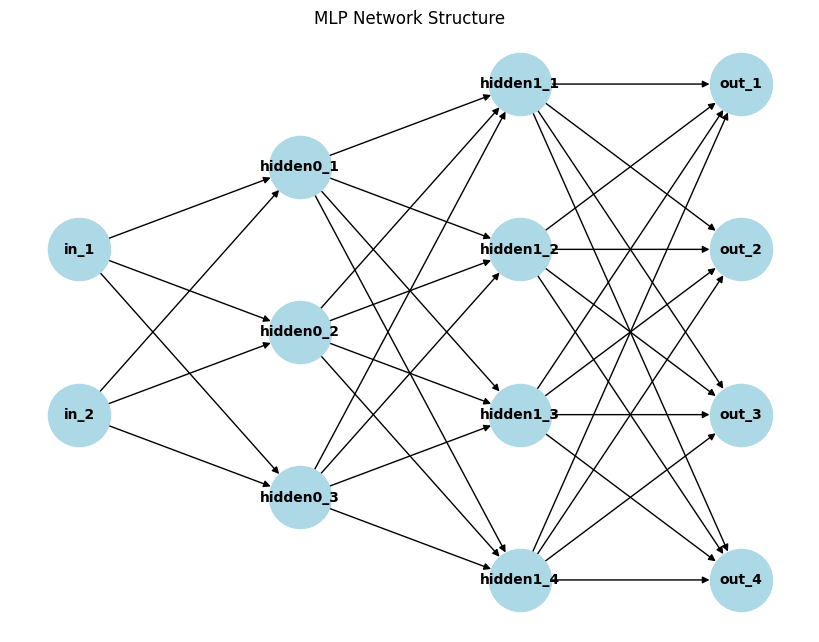

In [34]:
hidden_layer_sizes = [3,4]  # 隠れ層の数

import matplotlib.pyplot as plt
import networkx as nx

def draw_mlp_network(input_nodes, hidden_layers, output_nodes):
    """
    MLPのネットワークを描画する関数

    Parameters:
    - input_nodes: 入力層のノード数
    - hidden_layers: 隠れ層のノード数のリスト
    - output_nodes: 出力層のノード数
    """
    G = nx.DiGraph()

    # ノードの追加
    layers = [input_nodes] + hidden_layers + [output_nodes]
    layer_pos = []
    max_nodes = max(layers)

    for i, layer in enumerate(layers):
        # 中央揃えにするためのオフセット計算
        offset = (max_nodes - layer) / 2
        current_layer = []
        for j in range(layer):
            if i == 0:
                node_id = f'in_{j+1}'
            elif i == len(layers) - 1:
                node_id = f'out_{j+1}'
            else:
                node_id = f'hidden{i-1}_{j+1}'
            G.add_node(node_id, pos=(i, max_nodes - (j + offset)))
            current_layer.append(node_id)
        layer_pos.append(current_layer)

    # エッジの追加
    for i in range(len(layers) - 1):
        for node_start in layer_pos[i]:
            for node_end in layer_pos[i + 1]:
                G.add_edge(node_start, node_end)

    # ノードの位置を取得
    pos = nx.get_node_attributes(G, 'pos')

    # グラフの描画
    plt.figure(figsize=(8, 6))  # 横幅を800pxに設定するための調整
    nx.draw(G, pos, with_labels=True, node_size=2000, node_color="lightblue", font_size=10, font_weight="bold")
    plt.title('MLP Network Structure')
    plt.show()


# モデルの構築
mlp = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes, max_iter=1, warm_start=True, random_state=random_state)

# 構造の描画
draw_mlp_network(input_nodes=X_train_transformed.shape[1], hidden_layers=hidden_layer_sizes, output_nodes=len(feature_names))

モデルを定義できたら学習を行いましょう。
最大エポック数を調節してください。

**ネットワーク構造を書き換えた場合、上のセルを必ず実行して、反映させてから学習してください。**

  0%|          | 0/1000 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Epoch 1000/1000 - Train accuracy: 0.4857, Train loss: 0.5207, Val accuracy: 0.6818, Val loss: 0.3695


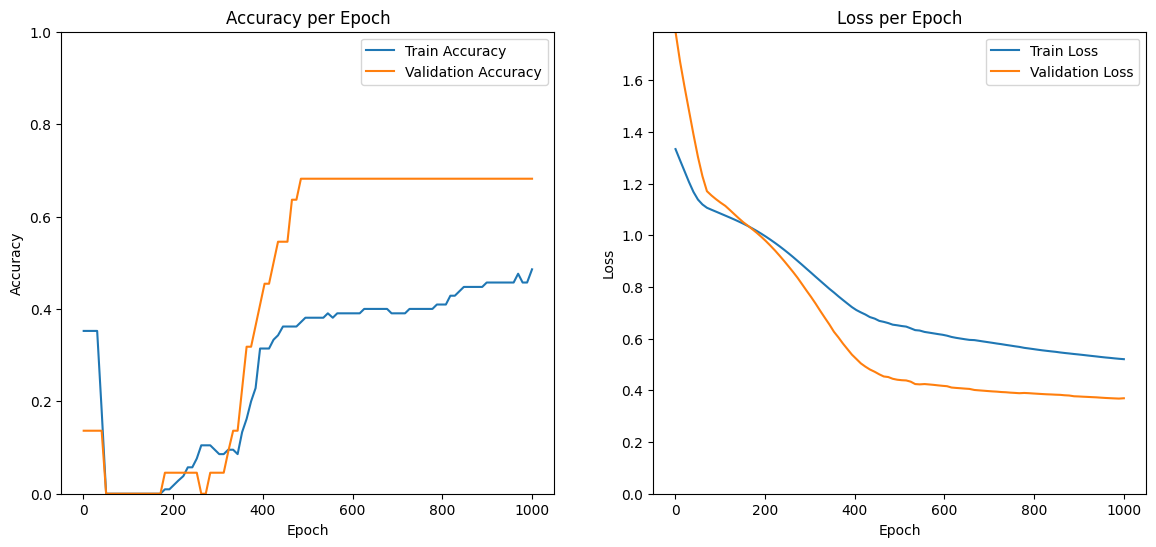

In [13]:
max_epochs = 1000           # 最大エポック数

# トレーニングループ
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# tqdmを使って進行状況バーを表示
with tqdm(total=max_epochs, leave=False) as pbar:
    for epoch in range(max_epochs):
        mlp.fit(X_train_transformed, y_train)

        # 教師データでの予測と評価
        y_train_pred = mlp.predict(X_train_transformed)
        y_train_pred_proba = mlp.predict_proba(X_train_transformed)
        train_accuracy = accuracy_score(y_train, y_train_pred)
        train_loss = log_loss(y_train, y_train_pred_proba)

        # 検証データでの予測と評価
        y_val_pred = mlp.predict(X_val_transformed)
        y_val_pred_proba = mlp.predict_proba(X_val_transformed)
        val_accuracy = accuracy_score(y_val, y_val_pred)
        val_loss = log_loss(y_val, y_val_pred_proba)

        # 記録
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)

        # tqdmの説明文を更新
        pbar.set_description(f"Epoch {epoch + 1}/{max_epochs} - Train loss: {train_loss:.4f}, Val loss: {val_loss:.4f}, Train acc: {train_accuracy:.4f}, Val acc: {val_accuracy:.4f}")
        pbar.update(1)

# 最後のエポックの結果を表示
print(f"Epoch {max_epochs}/{max_epochs} - Train accuracy: {train_accuracy:.4f}, Train loss: {train_loss:.4f}, Val accuracy: {val_accuracy:.4f}, Val loss: {val_loss:.4f}")

# プロット用の間引き
def reduce_points(data, num_points):
    if len(data) > num_points:
        indices = np.linspace(0, len(data) - 1, num_points, dtype=int)
        return [data[i] for i in indices]
    return data

# グラフで学習の様子を表示

num_points = 100
epochs = range(1, max_epochs + 1)
epochs_reduced = reduce_points(list(epochs), num_points)
train_accuracies_reduced = reduce_points(train_accuracies, num_points)
val_accuracies_reduced = reduce_points(val_accuracies, num_points)
train_losses_reduced = reduce_points(train_losses, num_points)
val_losses_reduced = reduce_points(val_losses, num_points)

# プロット
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs_reduced, train_accuracies_reduced, label='Train Accuracy')
plt.plot(epochs_reduced, val_accuracies_reduced, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.legend()
plt.title('Accuracy per Epoch')

plt.subplot(1, 2, 2)
plt.plot(epochs_reduced, train_losses_reduced, label='Train Loss')
plt.plot(epochs_reduced, val_losses_reduced, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0, max(max(train_losses_reduced), max(val_losses_reduced)))
plt.legend()
plt.title('Loss per Epoch')

plt.show()

#### **課題３**

- 学習では ＿＿＿＿＿＿ の値を小さくすることを目指します．
 - ある入力サンプルから得られた仮の出力（各クラスに属する＿＿＿＿）と，正解の ＿＿＿＿＿＿ 表現を比較して，その値が少しだけ小さくなるようにネットワークを更新します．この比較に用いる関数は ＿＿＿＿＿関数とよばれます．

- 左のグラフは＿＿＿＿＿＿，右のグラフは＿＿＿＿＿＿です．
 - 学習で小さくしようとしているのは右ですか，左ですか？

- エポックとは？ 今回は何エポックの学習が行われましたか？


### 教師データや検証データで試す

In [14]:
# 教師データでの予測
y_train_pred = mlp.predict(X_train_transformed)
y_train_pred_proba = mlp.predict_proba(X_train_transformed)

# 教師データでの評価
train_accuracy = accuracy_score(y_train, y_train_pred)
train_loss = log_loss(y_train, y_train_pred_proba)

print(f"教師データでの精度: {train_accuracy:.4f}")
print(f"教師データでの損失: {train_loss:.4f}")

# 検証データでの予測
y_val_pred = mlp.predict(X_val_transformed)
y_val_pred_proba = mlp.predict_proba(X_val_transformed)

# 検証データでの評価
val_accuracy = accuracy_score(y_val, y_val_pred)
val_loss = log_loss(y_val, y_val_pred_proba)

print(f"検証データでの精度: {val_accuracy:.4f}")
print(f"検証データでの損失: {val_loss:.4f}")

教師データでの精度: 0.4857
教師データでの損失: 0.5207
検証データでの精度: 0.6818
検証データでの損失: 0.3695


### 教師データを１個入力して試す

作成されたネットワークがどのように動作するのか、教師データを１個用いて確認してみます。

- **ネットワークへの入力（特徴量）**

    教師データから特定のサンプルを選び、その特徴量ベクトルを表示します。これは、ネットワーク（モデル）に入力されるデータで、各特徴量が数値として表現されています。

- **ネットワークの出力（確率）**

    選択した入力に対して、モデルが各クラスに属する確率を計算します。この確率は、入力がそれぞれのクラスに分類される可能性を示しており、各クラスに対して1つの確率値が出力されます。

- **推定されたクラス番号の one-hot 表現**

    モデルが予測したクラスのone-hot表現を表示します。one-hot表現とは、正解クラスを1、それ以外のクラスを0とするベクトル形式のことです。例えば4クラスの場合、[0, 0, 1, 0]はクラス3を示します。

- **クラス推定の表示（整数表現）**

    one-hot表現のベクトルを整数に変換し、予測されたクラスを数値として示します。

In [15]:
# 特徴量ベクトルを入力し、各クラスの確率を出力
sample_index = 1  # 任意のサンプルインデックス
sample_input = X_train_transformed[sample_index].reshape(1, -1)  # 1サンプルの入力データ
print("ネットワークへの入力（特徴量）　　 ：", sample_input)

# 確率の出力
class_probabilities = mlp.predict_proba(sample_input)
print("ネットワークの出力（確率）　　 　　：", class_probabilities)

# クラス推定
predicted_class = mlp.predict(sample_input)
print("推定されたクラス番号の one-hot 表現：", predicted_class)
print("推定されたクラス番号　　　　　　　 ：", np.argmax(predicted_class))


# クラス推定
predicted_class = mlp.predict(sample_input)
print("正解の one-hot 表現　　　　　　　　：", y_train[sample_index])
print("正解　　　　　　　　　　　　　　　 ：", np.argmax(y_train[sample_index]))

ネットワークへの入力（特徴量）　　 ： [[6.3 2.8]]
ネットワークの出力（確率）　　 　　： [[0.00179483 0.45789212 0.56689604]]
推定されたクラス番号の one-hot 表現： [[0 0 1]]
推定されたクラス番号　　　　　　　 ： 2
正解の one-hot 表現　　　　　　　　： [0. 0. 1.]
正解　　　　　　　　　　　　　　　 ： 2


#### **課題４**

- 出力を読み取りながら埋めてください：

  あるサンプルの ＿＿＿＿＿＿＿ をネットワークに入力したところ，＿＿＿＿＿＿ が出力された．

  出力は，そのサンプルが各クラスに属する確率を表すものである．その中では ＿＿＿＿ 番目のクラスが最大となったことから，推定されたクラスは ＿＿＿＿ となった．

- この結果をもとに，更に学習をするとしたら…

＿＿＿＿＿関数を用いて ＿＿＿＿＿＿＿ と ＿＿＿＿＿＿ を比較し，その関数が小さくなるようにネットワークを修正する．その修正の処理を ＿＿＿＿＿ という[（参考）](https://hogetech.info/ml/dl/backpropagation)．

### 2次元プロットによるモデルの可視化

2次元のみで学習を行った場合、得られたモデルの分類領域を視覚化します。大量のサンプル点を生成し、その点に対するモデルの予測結果をプロットします。

<ipython-input-16-b3e22f1fbae9>:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  palette = plt.cm.get_cmap('tab10', len(np.unique(np.argmax(y, axis=1))))


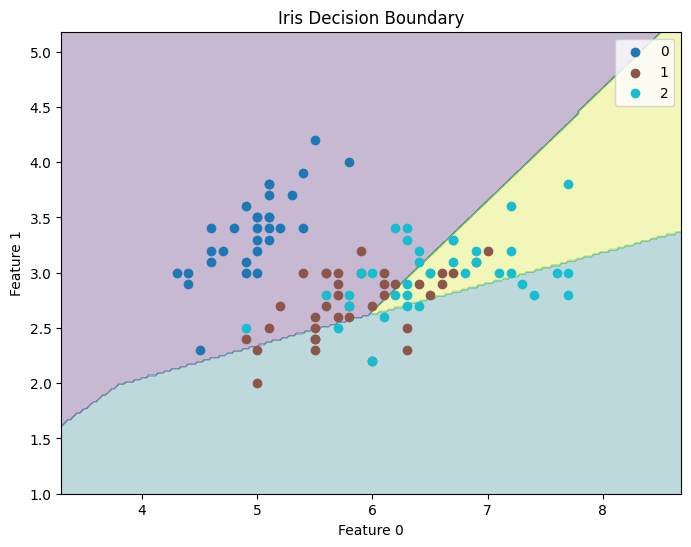

In [16]:
# グリッドサーチによる領域プロット
def plot_decision_boundary(clf, X, y, feature_indices, title=""):
    # グリッドを生成
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))

    # グリッド全体で予測を実行
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = np.argmax(Z, axis=1)
    Z = Z.reshape(xx.shape)

    # プロットの描画
    plt.figure(figsize=(8, 6))
    plt.contourf(xx, yy, Z, alpha=0.3)
    palette = plt.cm.get_cmap('tab10', len(np.unique(np.argmax(y, axis=1))))
    for target in np.unique(np.argmax(y, axis=1)):
        subset = X[np.argmax(y, axis=1) == target]
        plt.scatter(subset[:, feature_indices[0]], subset[:, feature_indices[1]], label=target, color=palette(target))
    plt.xlabel(f"Feature {feature_indices[0]}")
    plt.ylabel(f"Feature {feature_indices[1]}")
    plt.title(title)
    plt.legend()
    plt.show()

# 特徴量の組み合わせを選んでプロット
if use_two_features == True:
  plot_decision_boundary(mlp, X_train_transformed, y_train, feature_indices, title=f"{dataset_name} Decision Boundary")

#### **課題５**

- クラスを分ける境界のことを ＿＿＿＿＿＿＿＿ という．
 - これを適切な位置に決めることが学習であるともいえる．
 - 各クラスが概ね良好に分離できていれば学習は成功
 - あまりにも細かくクネクネと分離している状況は ＿＿＿＿＿ とされる．教師データでは高い精度を得られるが，テストデータにはむしろ精度が下がってしまう．学習のしすぎを防ぐために，＿＿＿データを用いてハイパーパラメータを調節したり，ちょうどよいタイミングでで学習を停止したりする工夫が行われる．

### テストデータでの評価

モデルの最終評価として、テストデータを使用します。

テストデータの番号を指定してください: 3
入力特徴量:


,正解クラス番号,正解クラス名,推論クラス番号,推論クラス名,ガクの長さ,ガクの幅
0,0,setosa,0,setosa,5.4,3.9


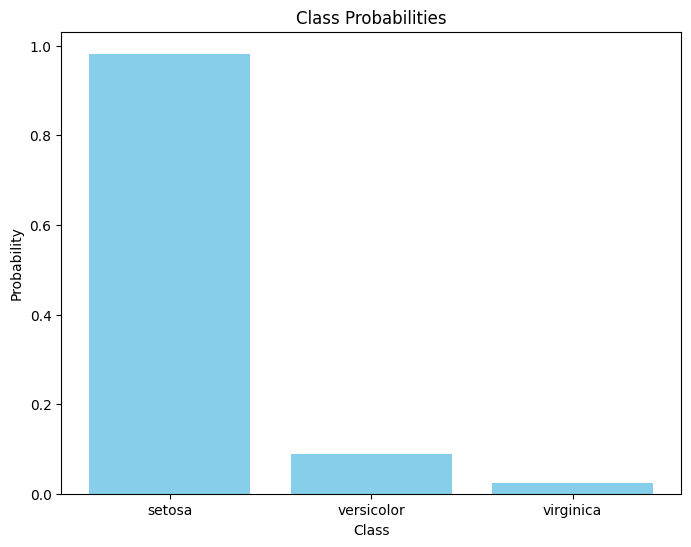

In [17]:
# テストデータの番号を指定
test_index = int(input("テストデータの番号を指定してください: "))

if 0 <= test_index < len(X_test_transformed):
    test_sample = X_test_transformed[test_index].reshape(1, -1)
    probabilities = mlp.predict_proba(test_sample)[0]
    predicted_class_index = np.argmax(probabilities)
    predicted_class_name = target_names[predicted_class_index]
    true_class_index = np.argmax(y_test[test_index])
    true_class_name = target_names[true_class_index]

    # 入力特徴量の表示
    test_sample_df = pd.DataFrame(test_sample, columns=clms)
    test_sample_df["正解クラス番号"] = true_class_index
    test_sample_df["正解クラス名"] = true_class_name
    test_sample_df["推論クラス番号"] = predicted_class_index
    test_sample_df["推論クラス名"] = predicted_class_name
    test_sample_df = test_sample_df[
        ["正解クラス番号", "正解クラス名", "推論クラス番号", "推論クラス名"] + clms.tolist()
    ]

    print("入力特徴量:")
    display(test_sample_df)

    # 出力確率の可視化
    plt.figure(figsize=(8, 6))
    plt.bar(target_names, probabilities, color='skyblue')
    plt.xlabel('Class')
    plt.ylabel('Probability')
    plt.title('Class Probabilities')
    plt.show()
else:
    print("無効なテストデータの番号です。")

テストデータのすべてのサンプルについて同様の表を見てみましょう．

In [18]:
# 全テストデータの結果を表示
all_test_samples = []

for i in range(len(X_test_transformed)):
    test_sample = X_test_transformed[i].reshape(1, -1)
    probabilities = mlp.predict_proba(test_sample)[0]
    predicted_class_index = np.argmax(probabilities)
    predicted_class_name = target_names[predicted_class_index]
    true_class_index = np.argmax(y_test[i])
    true_class_name = target_names[true_class_index]

    test_sample_df = pd.DataFrame(test_sample, columns=clms)
    test_sample_df["正解クラス番号"] = true_class_index
    test_sample_df["正解クラス名"] = true_class_name
    test_sample_df["推論クラス番号"] = predicted_class_index
    test_sample_df["推論クラス名"] = predicted_class_name
    test_sample_df = test_sample_df[
        ["正解クラス番号", "正解クラス名", "推論クラス番号", "推論クラス名"] + clms.tolist()
    ]

    all_test_samples.append(test_sample_df)

all_test_samples_df = pd.concat(all_test_samples, ignore_index=True)

print("全テストデータの結果:")
display(all_test_samples_df)

全テストデータの結果:


,正解クラス番号,正解クラス名,推論クラス番号,推論クラス名,ガクの長さ,ガクの幅
0,0,setosa,0,setosa,5.2,4.1
1,2,virginica,2,virginica,6.7,3.0
2,2,virginica,2,virginica,6.7,2.5
3,0,setosa,0,setosa,5.4,3.9
4,2,virginica,2,virginica,6.3,2.5
5,1,versicolor,2,virginica,6.0,3.4
6,1,versicolor,2,virginica,6.8,2.8
7,0,setosa,0,setosa,5.5,3.5
8,1,versicolor,2,virginica,6.2,2.2
9,1,versicolor,2,virginica,6.0,2.9


さらに、テストデータにおいて精度（正解率）および損失を計算してみましょう。

In [19]:
# テストデータでの予測
y_test_pred = mlp.predict(X_test_transformed)
y_test_pred_proba = mlp.predict_proba(X_test_transformed)

# テストデータでの評価
test_accuracy = accuracy_score(y_test, y_test_pred)
test_loss = log_loss(y_test, y_test_pred_proba)

print(f"テストデータでの精度: {test_accuracy:.4f}")
print(f"テストデータでの損失: {test_loss:.4f}")

テストデータでの精度: 0.5217
テストデータでの損失: 0.5551


#### **課題６**

学んだことをもとに，ご自身の言葉でまとめてください．

- データセット，クラス，特徴量
- ニューラルネットワークの入力と出力
- 学習とは，何を用いて何をするもの？
- 学習されたモデルをどうやって使うと，新たなサンプルのクラスを推定できる？



## 発展

今回，１サンプルの特徴量は，多くても 30 次元でした．

しかし，たとえば画像を判別するなら，とても小さな画像でも 縦 32 × 横 32 × RGB 3チャンネル ＝ 3072 次元くらいはあります．この場合，画像を特徴量に変換（**特徴抽出**）した上で，判別に使うことになります．

この特徴抽出をネットワーク内部で行ってくれるものとして有名なのが **畳み込み層**（Convolutional Layer）です．また，それを含むニューラルネットワークが畳み込みニューラルネットワーク（Convolutional Neural Network; **CNN**）です．

- 多次元配列の扱いについては [NumPy の演習](https://github.com/shizoda/education/blob/main/machine_learning/numpy.ipynb)

- 画像の扱いや畳み込みについては [画像処理の演習](https://github.com/shizoda/education/blob/main/machine_learning/image_proc.ipynb)

これらをご存知の方はこのまま

- [CNN を用いた画像分類の演習](https://github.com/shizoda/education/blob/main/machine_learning/cnn/cifar10_pytorch.ipynb)

に進んでください．